In [1]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle as plk
import importlib.util
from IPython.display import display, Math

###############################################################
#LINUX PATH

#sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
#import lumapi
#sys.path.append(os.path.dirname('/media/leonardo/datam02/Ring Resonator - Leonardo Pessôa/')) #Current directory

###############################################################
# WINDOWS PATH

spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec_win)
os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
sys.path.append(os.path.dirname('D:/AAAAAAAArquivos/Facul/Capacitação/GitHub/Ring-Resonator'))
spec_win.loader.exec_module(lumapi)



C:\Users\lecob\AppData\Local\Temp\ipykernel_22672\203226617.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


# Theorical Graphs

In [2]:
ns = 1.444
nf = 3.476
lambda0 = 1550e-9
pi = np.pi 
k0 = 2*pi/lambda0
c0 = 299792458
neff = 1.91
ng = 4.63
L = 20.3e-6
Cband = np.linspace(1.530e-6, 1.565e-6, 2000)
beta = (neff*2*pi)/Cband
band = np.linspace(1500e-9, 1600e-9, 2000)

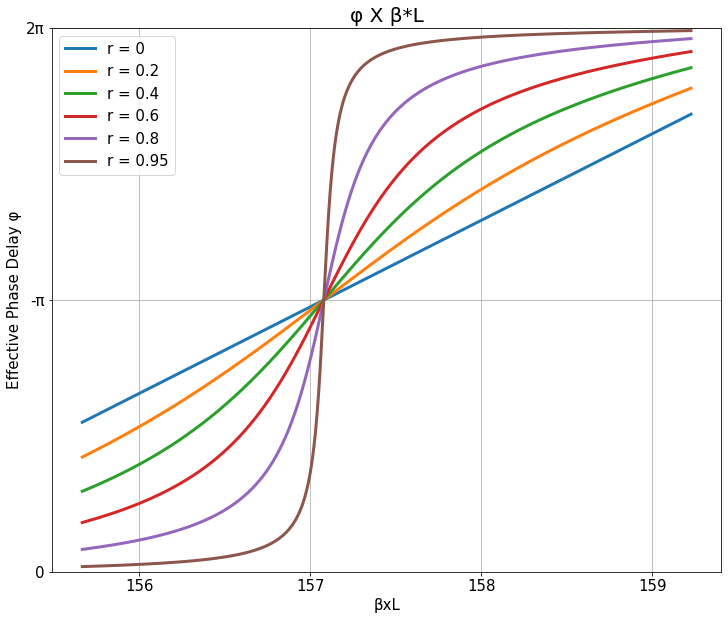

In [3]:
figure1 = plt.figure(figsize=(12, 10))
a = 1
r = [0, 0.2, 0.4, 0.6, 0.8, 0.95]
phi = beta*L

for i in range(0,len(r)):
    phase = pi + phi + np.arctan((r[i]*np.sin(phi))/(a-r[i]*np.cos(phi))) + np.arctan(a*r[i]*np.sin(phi)/(1-a*r[i]*np.cos(phi))) 
    plt.grid(True)
    plt.title('φ X β*L', size = 20)
    plt.ylabel('Effective Phase Delay φ', size = '15')
    plt.xlabel('βxL', size = '15')
    phase = phase%(2*pi)
    plt.xticks(np.arange(154,160, step = 1), size = '15')
    plt.yticks([0, pi, 2*pi], ['0', '-π', '2π'], size = '15')
    plt.ylim([0,2*pi])
    plt.plot(phi, phase, label = 'r = ' + str(r[i]), linewidth = 3)
    plt.legend(loc = 'upper left', prop = {'size': 15})
    #plt.xlim([155,160])
    #plt.xlim([-pi,pi])
    #plt.xticks([-pi, -pi/2, 0, pi/2, pi], ['-π', '-π/2', '0', 'π/2', 'π'], size = '15')

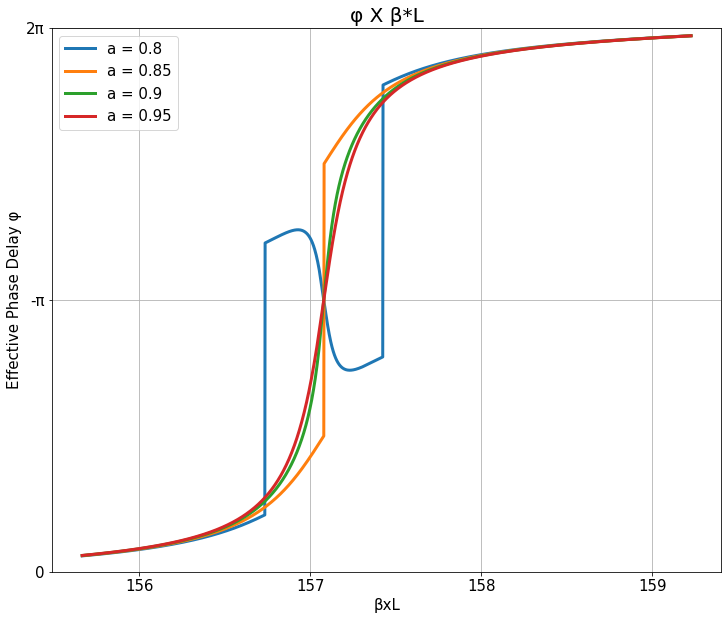

In [4]:
figure2 = plt.figure(figsize=(12, 10))
a = [0.8, 0.85, 0.9, 0.95]
r = 0.85
phi = beta*L

for i in range(0,len(a)):
    phase = pi + phi + np.arctan((r*np.sin(phi))/(a[i]-r*np.cos(phi))) + np.arctan((a[i]*r*np.sin(phi))/(1-(a[i]*r*np.cos(phi))))  
    plt.grid(True)
    plt.title('φ X β*L', size = 20)
    plt.ylabel('Effective Phase Delay φ', size = '15')
    plt.xlabel('βxL', size = '15')
    phase = phase%(2*pi)
    plt.xticks(np.arange(154,160, step = 1), size = '15')
    #plt.xlim([155,160])
    plt.yticks([0, pi, 2*pi], ['0', '-π', '2π'], size = '15')
    plt.ylim([0,2*pi])
    plt.plot(phi, phase, label = 'a = ' + str(a[i]), linewidth = 3)
    plt.legend(loc = 'upper left', prop = {'size': 15})
    #plt.xlim([-pi,pi])
    #plt.xticks([-pi, -pi/2, 0, pi/2, pi], ['-π', '-π/2', '0', 'π/2', 'π'], size = '15')

FWHM = 0.9505 nm
Fsr = 25.6 nm
Theorical L = 20.3 μm
Theorical Q = 1630.7206733298265
Theorical Finesse = 31.95162267342691
K² = 0.0936


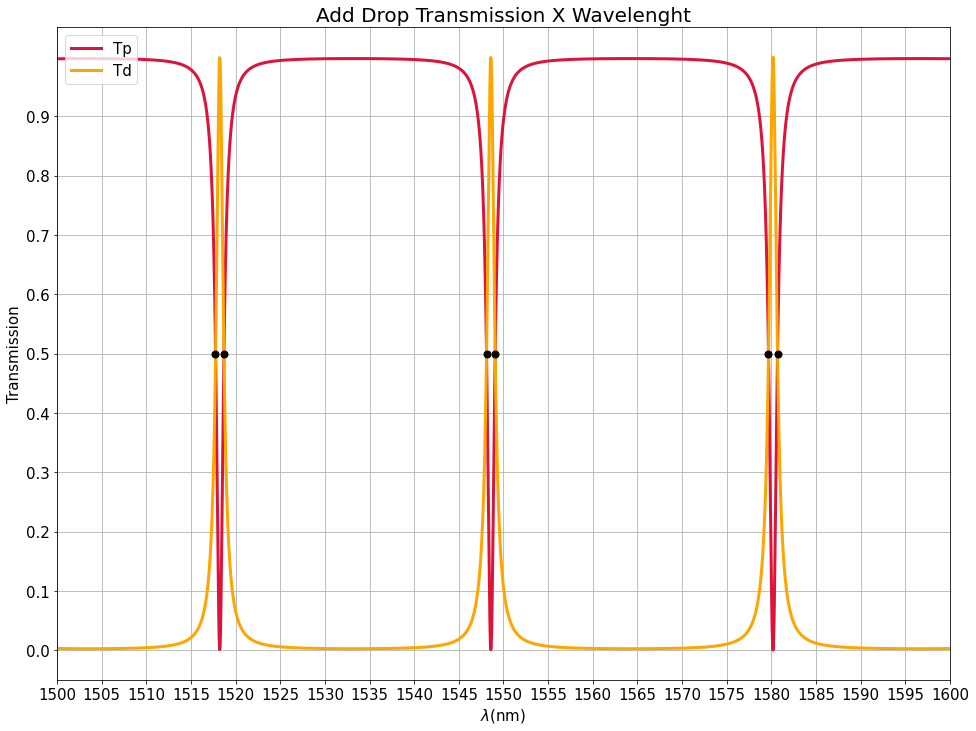

In [5]:
figure3 = plt.figure(figsize=(16, 12))

a = 1
Fsr = 25.6e-9
FWHM = 0.8e-9
neff = 1.91
r1 = 0.952046
r2 = 0.952046
band = np.linspace(1500e-9, 1600e-9,2000)
Cband = np.linspace(1.530e-6, 1.565e-6, 2000)

beta = (neff*2*pi)/band
L = (((1550e-9)**2)/(ng*Fsr))
k = round(1-r1*r2,4)

phi = 2*beta*L

Tp = ((r2**2)*(a**2) - (2*r1*r2*a*np.cos(phi)) + r1**2)/(1 - 2*r1*r2*a*np.cos(phi) + (r1*r2*a)**2)
Td = ((1-r1**2)*(1-r2**2)*a)/(1 - 2*r1*r2*a*np.cos(phi) + (r1*r2*a)**2)
Func = np.linspace(0.5 ,0.5, 2000)

Q = (pi*ng*L*(np.sqrt(r1*r2*a)))/(1550e-9*(1-r1*r2*a))
Finesse = (pi*(np.sqrt(r1*r2*a)))/(1 - r1*r2*a)

plt.plot(band*1e9, Tp, linewidth = "3", color = 'crimson', label = 'Tp')
plt.plot(band*1e9, Td, linewidth = "3", color = 'orange', label = 'Td')
plt.xlim(band[0]*1e9,band[-1]*1e9)
plt.ylabel("Transmission", fontsize = '15')
plt.xlabel(r'$\lambda$(nm)', fontsize = '15')
plt.xticks(np.arange(1500, 1605, step = 5), size = '15')
plt.yticks(np.arange(0, 1, step = 0.1), size = '15')
plt.legend(loc = 'upper left', prop = {'size': 15})
plt.grid()
plt.title('Add Drop Transmission X Wavelenght', size = '20')
idx = np.argwhere(np.diff(np.sign(Func - Tp)) != 0).reshape(-1) + 0
values = np.zeros(len(idx))
for i in range(len(idx)):
    plt.plot(((band[idx[i]]+band[idx[i]+1])/2.)*1e9,(Func[idx[i]]+Func[idx[i]+1])/2., marker = "o", markersize = 7, markeredgecolor = "black", markerfacecolor = 'black')
    values[i] = float(((band[idx[i]]+band[idx[i]+1])/2.)*1e9)
FWHM = round(values[3] - values[2], 4)
Q = (1550)/FWHM
print('FWHM = ' + str(FWHM) + ' nm')
print('Fsr = ' + str(Fsr*1e9) + ' nm')
print('Theorical L = ' + str(round(L*1e6,1)) + ' μm')
print('Theorical Q = '+ str(Q))
print('Theorical Finesse = '+ str(Finesse))
print('K² = ' + str(k))
Lc = 1427e-9

# Lumerical Mode


In [2]:
lum = lumapi.MODE(filename = 'ring_resonator.lms')

Guide Generation


In [74]:
lum.switchtolayout()
lum.selectall() 
lum.delete()

mesh = 0.01e-6
r = 3e-6
width = 0.4e-6
height = 0.18e-6
lc = 0
gap = 150e-9
material = 'Si (Silicon) - Palik'
background = 'SiO2 (Glass) - Palik'


lum.addrect()
lum.set({
  'x' : 0,
  'y' : 0,
  'z' : -2e-6,
  'x span' : 16e-6,
  'y span' : 16e-6,
  'z span' : 4e-6,
  'material' : background,
})

lum.addfde()
lum.set({
  'solver type' : '2D X normal',
  'x' : 0e-6,
  'y' : 3.6e-6,
  'y span' : 4e-6,
  'z' : 0.075e-6,
  'z span' : 1e-6,
  'mesh cells z' : 100,
  'mesh cells y' : 200,
})

lum.addvarfdtd()
lum.set({
  'x' : 0,
  'x span' : 3*r,
  'y' : 0e-6,
  'y span' : 3*r,
  'z' : 0,
  'z span' : 1e-6,
  'background material' : background,
  'mesh accuracy' : 4,
  'Z min bc' : 'Symmetric',
  'x0' : 0,
  'y0' : r+gap+width,
  'set simulation bandwidth' : 1,
  'simulation wavelength min' : 1.53e-6,
  'simulation wavelength max' : 1.565e-6,
})

lum.addobject('ring_resonator')
lum.set({
    "x"           : -7e-6,
    "y"           : 0,
    "z"           : height/2,
    "gap"         : gap,
    "radius"      : r,
    "base width"  : width,
    "base height" : height,
    "base angle"  : 90,
    "material"    : material,
    "name"        : 'Ring Resonator',
    "x span"      : 14e-6,
    'lc'          : lc
      })

lum.addpower()
lum.set({
  'monitor type' : 'Linear Y',
  'name' : 'add',
  'x' : 1.25*r,
  'y' : r+gap+width,
  'y span' : r,
  'z' : height/2
})

lum.addpower()
lum.set({
  'monitor type' : 'Linear Y',
  'name' : 'drop',
  'x' : -1.25*r,
  'y' : -(r+gap+width),
  'y span' : r,
  'z' : height/2
})

lum.addmodesource()
lum.set({
  'x' : -(r*1.25),
  'y' : r + gap + width,
  'y span' : 2e-6,
  'wavelength start': 1530e-9,
  'wavelength stop': 1565e-9,
})

lum.addmesh()
lum.set({
  "set maximum mesh step"      : 1,
  "override x mesh"            : 1,
  "override y mesh"            : 1,
  "override z mesh"            : 1,
  "x"                          : 0,
  "y"                          : r,
  "x span"                     : r,
  "y span"                     : r/2,
  "dx"                         : mesh,
  "dy"                         : mesh,
  "dz"                         : mesh,
  "z"                          : 0,
  "z span"                     : 0.5e-6,
})

lum.addtime()
lum.set({
  'x' : -1.25*r,
  'y' : -(r + gap + width),
  'name' : 'drop_time'
})

lum.addtime()
lum.set({
  'x' : 1.25*r,
  'y' : (r + gap + width),
  'name' : 'add_time'
})

Lc Sweep with an straight waveguide

In [77]:
# Guide modifications for the sweep

lum.switchtolayout()

lum.addrect()
lum.set({
  'name'  : 'Extension 1',
  'x min' : r -(width/2) + lc,
  'x max' : r +(width/2) + lc,
  'y max' : 0,
  'y min' : -r,
  'z min'     : 0,
  'z max'     : height,
  'material' : material,
})

lum.addrect()
lum.set({
  'name'  : 'Extension 2',
  'x min' : -(r +(width/2) + lc),
  'x max' : -(r -(width/2) + lc),
  'y max' : 0,
  'y min' : -r,
  'z min'     : 0,
  'z max'     : height,
  'material' : material,
})


lum.setnamed('drop', {
  'monitor type' : 'Linear X',
  'x' : r,
  'y' : -r/2,
  'x span' : r,
  'z' : height/2
})

lum.setnamed('Ring Resonator::outer_bottom',{
    'enabled' :  0,
})

lum.setnamed('Ring Resonator::arc2',{
    'enabled' :  0,
})

lum.setnamed('Ring Resonator::arc3',{
    'enabled' :  0,
})

lum.setnamed('varFDTD', {
    'x' : 0,
    'x span' : 3*r,
    'y' : r/2,
    'y span' : 3*r,
    'z' : 0,
    'x0' : 0,
    'y0' : r/2+gap+width,
})

lum.setnamed('add',{
  'y' : r+gap+width,
  'x' : 1.25*r,
})

lum.setnamed('rectangle', {
  'x span' : 5*r,
  'y span' : 5*r,
  })

lum.setnamed('drop_time', {
  'x' : r,
  'y' : -r/2
})

lum.setnamed('add_time',{
  'y' : r+gap+width,
  'x' : 1.25*r,
})

{!!}

{!!}



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


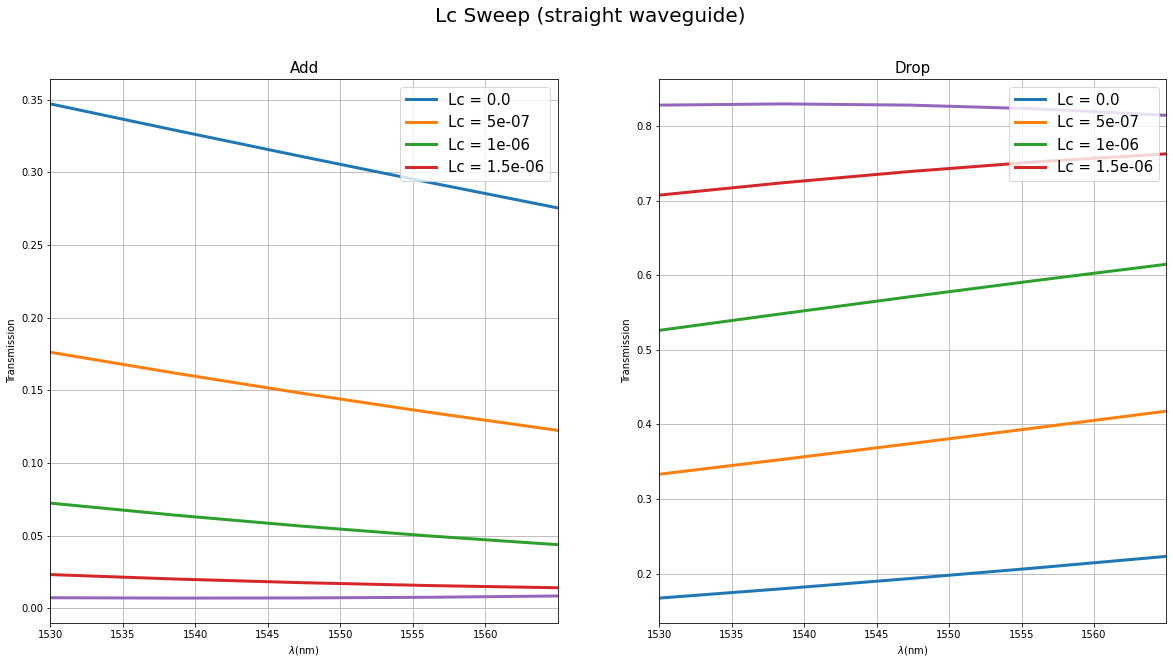

In [79]:
#Plots

figure12,fig = plt.subplots(1, 2, figsize=(20,10))

values = np.linspace(0, 2e-6, 5)
add = lum.getsweepresult('Lc Sweep', 'add')
drop = lum.getsweepresult('Lc Sweep', 'drop')
wavelenght = add['lambda']
add = abs((add['T'])**2)
drop = np.transpose(abs((drop['T'])**2))
add = np.transpose(add)

for i in range(len(add)):
    aux = values[i]
    fig[0].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[0].set_ylabel("Transmission", fontsize = '10')
    fig[0].set_xlabel(r'$\lambda$(nm)', fontsize = '10')
    fig[0].set_xticks(np.arange(1530, 1565, step = 5), size = '10')
    fig[0].set_title('Add', size = 15)
    fig[0].legend(loc = 'upper right', prop = {'size': 15})
    fig[0].plot(wavelenght*1e9, add[i], label = 'Lc = ' + str(values[i]), linewidth = 3)
    fig[0].grid()

    fig[1].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[1].set_ylabel("Transmission", fontsize = '10')
    fig[1].set_xlabel(r'$\lambda$(nm)', fontsize = '10')
    fig[1].set_xticks(np.arange(1530, 1565, step = 5), size = '10')
    fig[1].set_title('Drop', size = 15)
    fig[1].legend(loc = 'upper right', prop = {'size': 15})
    fig[1].plot(wavelenght*1e9, drop[i], label = 'Lc = ' + str(values[i]), linewidth = 3)
    fig[1].grid()

    figure12.suptitle('Lc Sweep (straight waveguide)', size = '20')

plt.savefig("figure12")

Lc Sweep with an bent waveguide 3μm

In [10]:
# Guide modifications for the sweep

bendr = 3e-6

lum.addrect()
lum.set({
  'name'  : 'Extension 1',
  'x min' : r -(width/2) + lc,
  'x max' : r +(width/2) + lc,
  'y max' : 0,
  'y min' : -r,
  'z min'     : 0,
  'z max'     : height,
  'material' : material,
})

lum.addrect()
lum.set({
  'name'  : 'Extension 2',
  'x min' : -(r +(width/2) + lc),
  'x max' : -(r -(width/2) + lc),
  'y max' : 0,
  'y min' : -r,
  'z min'     : 0,
  'z max'     : height,
  'material' : material,
})

lum.addrect()
lum.set({
  'name'  : 'Extension 3',
  'x min' : bendr -(width/2) + lc,
  'x max' : bendr +(width/2) + lc,
  'y max' : bendr + 2*r + width + gap,
  'y min' : bendr + r + width + gap,
  'z min'     : 0,
  'z max'     : height,
  'material' : material,
})

lum.addrect()
lum.set({
  'name'  : 'Extension 4',
  'x max' : -(bendr -(width/2) + lc),
  'x min' : -(bendr +(width/2) + lc),
  'y max' : bendr + 2*r + width + gap,
  'y min' : bendr + r + width + gap,
  'z min'     : 0,
  'z max'     : height,
  'material' : material,
})

lum.setnamed('Ring Resonator::outer_bottom',{
    'enabled' :  0,
})

lum.setnamed('Ring Resonator::arc2',{
    'enabled' :  0,
})

lum.setnamed('Ring Resonator::arc3',{
    'enabled' :  0,
})

lum.setnamed('varFDTD', {
    'x' : 0,
    'x span' : 3*bendr,
    'y' : bendr+0.5e-6,
    'y span' : 3*bendr+1e-6,
    'z' : 0,
    'x0' : 0,
    'y0' : 0,
})

lum.setnamed('Ring Resonator::outer_top', 'enabled', 0)
lum.setnamed('rectangle', 'enabled', 0)

lum.addring()
lum.set({
"y" : r + bendr + width + gap,
"z": height/2,
"z span": height,
"outer radius":bendr +(width/2) + lc,
"inner radius":bendr -(width/2) + lc,
"theta start": 180,
"theta stop": 360,
"material"  : material
})

lum.setnamed('add',{
  'monitor type' : 'Linear X',
  'x' : bendr,
  'y' : bendr + r + 1.5e-6,
  'x span' : 2e-6,
  'z' : height/2,
})

lum.addpower()
lum.set({
  'monitor type' : 'Linear X',
  'name' : 'drop',
  'x' : r,
  'y' : -1e-6,
  'x span' : 2e-6,
  'z' : height/2,
})

lum.setnamed("source", {
  'injection axis' : 'y-axis',
  'direction'      : 'Backward',
  'x'              : -bendr,
  'y'              : bendr + r + 1.5e-6,
  'x span'         : bendr       
})

{!!}

{!!}

{!!}

{!!}



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


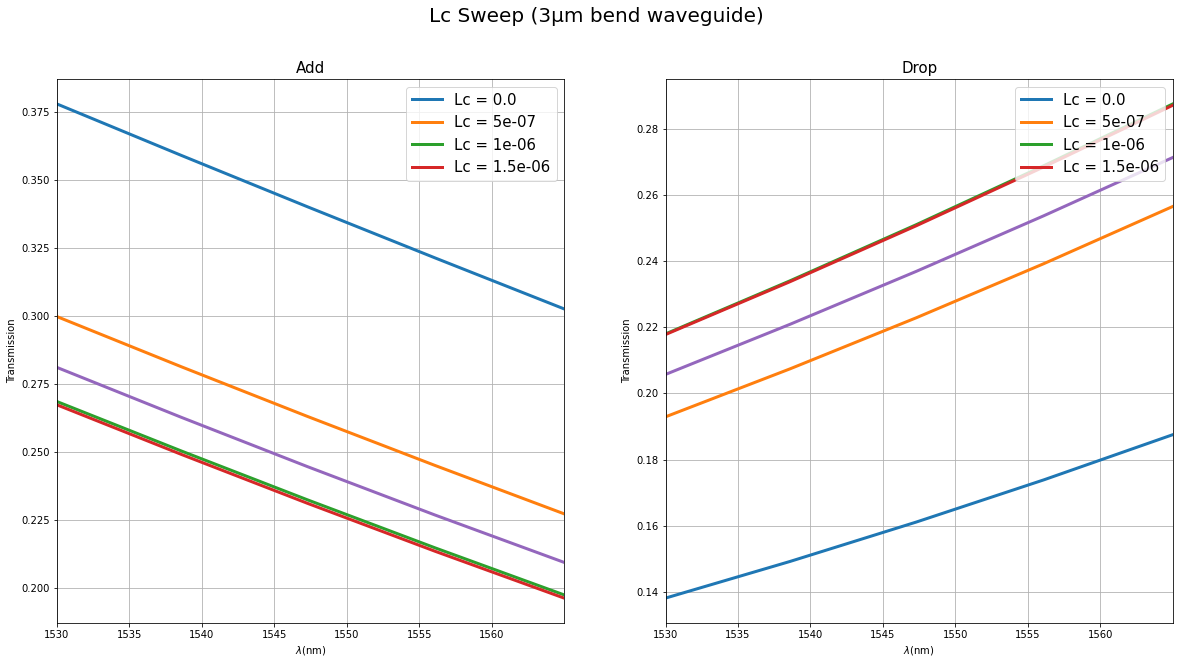

In [11]:
# Plots

figure13,fig = plt.subplots(1, 2, figsize=(20,10))

values = np.linspace(0, 2e-6, 5)
add = lum.getsweepresult('Lc Sweep3um', 'add')
drop = lum.getsweepresult('Lc Sweep3um', 'drop')
wavelenght = add['lambda']
add = abs((add['T'])**2)
drop = np.transpose(abs((drop['T'])**2))
add = np.transpose(add)

for i in range(len(add)):
    aux = values[i]
    fig[0].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[0].set_ylabel("Transmission", fontsize = '10')
    fig[0].set_xlabel(r'$\lambda$(nm)', fontsize = '10')
    fig[0].set_xticks(np.arange(1530, 1565, step = 5), size = '10')
    fig[0].set_title('Add', size = 15)
    fig[0].legend(loc = 'upper right', prop = {'size': 15})
    fig[0].plot(wavelenght*1e9, add[i], label = 'Lc = ' + str(values[i]), linewidth = 3)
    fig[0].grid()

    fig[1].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[1].set_ylabel("Transmission", fontsize = '10')
    fig[1].set_xlabel(r'$\lambda$(nm)', fontsize = '10')
    fig[1].set_xticks(np.arange(1530, 1565, step = 5), size = '10')
    fig[1].set_title('Drop', size = 15)
    fig[1].legend(loc = 'upper right', prop = {'size': 15})
    fig[1].plot(wavelenght*1e9, drop[i], label = 'Lc = ' + str(values[i]), linewidth = 3)
    fig[1].grid()

    figure13.suptitle('Lc Sweep (3μm bend waveguide)', size = '20')
plt.savefig('figure13')

Lc Sweep with an bent waveguide 5μm

In [12]:
# Guide modifications for the sweep

bendr = 5e-6

lum.addrect()
lum.set({
  'name'  : 'Extension 1',
  'x min' : r -(width/2) + lc,
  'x max' : r +(width/2) + lc,
  'y max' : 0,
  'y min' : -r,
  'z min'     : 0,
  'z max'     : height,
  'material' : material,
})

lum.addrect()
lum.set({
  'name'  : 'Extension 2',
  'x min' : -(r +(width/2) + lc),
  'x max' : -(r -(width/2) + lc),
  'y max' : 0,
  'y min' : -r,
  'z min'     : 0,
  'z max'     : height,
  'material' : material,
})

lum.addrect()
lum.set({
  'name'  : 'Extension 3',
  'x min' : bendr -(width/2) + lc,
  'x max' : bendr +(width/2) + lc,
  'y max' : bendr + 2*r + width + gap,
  'y min' : bendr + r + width + gap,
  'z min'     : 0,
  'z max'     : height,
  'material' : material,
})

lum.addrect()
lum.set({
  'name'  : 'Extension 4',
  'x max' : -(bendr -(width/2) + lc),
  'x min' : -(bendr +(width/2) + lc),
  'y max' : bendr + 2*r + width + gap,
  'y min' : bendr + r + width + gap,
  'z min'     : 0,
  'z max'     : height,
  'material' : material,
})

lum.setnamed('Ring Resonator::outer_bottom',{
    'enabled' :  0,
})

lum.setnamed('Ring Resonator::arc2',{
    'enabled' :  0,
})

lum.setnamed('Ring Resonator::arc3',{
    'enabled' :  0,
})

lum.setnamed('varFDTD', {
    'x' : 0,
    'x span' : 3*bendr,
    'y' : 0.75*bendr,
    'y span' : 2.5*bendr,
    'z' : 0,
    'x0' : 0,
    'y0' : -width - gap - width/2,
})

lum.setnamed('Ring Resonator::outer_top', 'enabled', 0)
lum.setnamed('rectangle', 'enabled', 0)

lum.addring()
lum.set({
"y" : r + bendr + width + gap,
"z": height/2,
"z span": height,
"outer radius":bendr +(width/2) + lc,
"inner radius":bendr -(width/2) + lc,
"theta start": 180,
"theta stop": 360,
"material"  : material
})

lum.setnamed('add',{
  'monitor type' : 'Linear X',
  'x' : bendr,
  'y' : bendr + r + 1.5e-6,
  'x span' : 2e-6,
  'z' : height/2,
})

lum.addpower()
lum.set({
  'monitor type' : 'Linear X',
  'name' : 'drop',
  'x' : r,
  'y' : -1e-6,
  'x span' : 2e-6,
  'z' : height/2,
})

lum.setnamed("source", {
  'injection axis' : 'y-axis',
  'direction'      : 'Backward',
  'x'              : -bendr,
  'y'              : bendr + r + 1.5e-6,
  'x span'         : bendr       
})

{!!}

{!!}

{!!}

{!!}

{!!}



C:\Program Files\Lumerical\v202\api\python\lumapi.py:138: UserWarning: Multiple objects named '::model::ring'. Use of this object may give unexpected results.
  warnings.warn(message)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


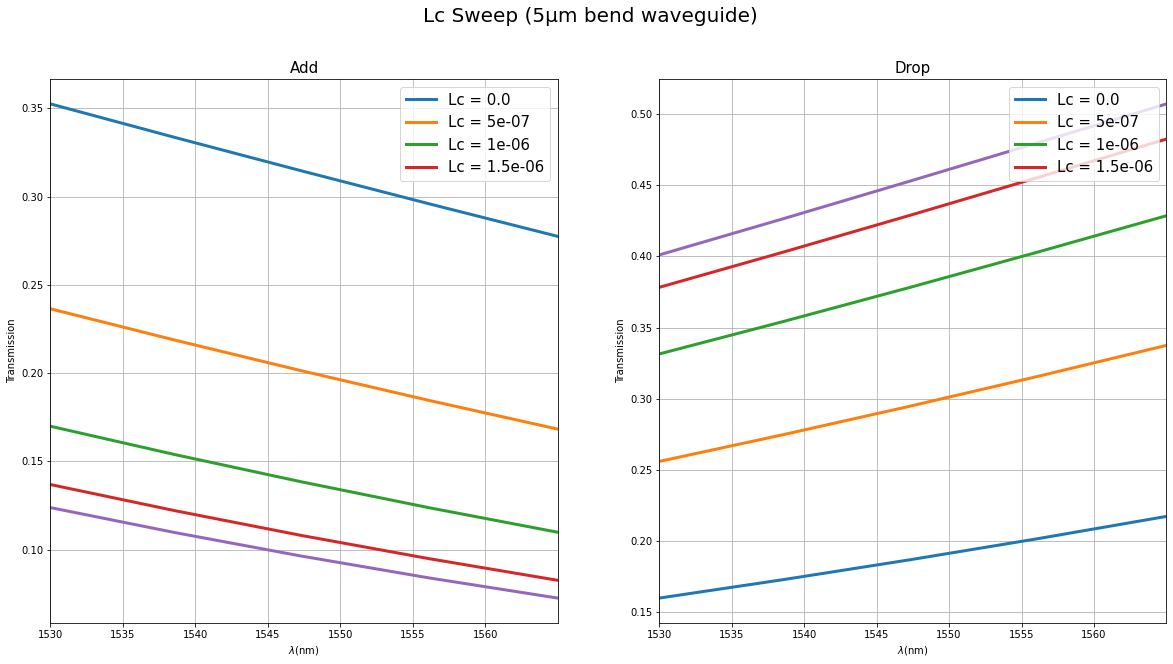

In [13]:
# Plots

figure14,fig = plt.subplots(1, 2, figsize=(20,10))

values = np.linspace(0, 2e-6, 5)
add = lum.getsweepresult('Lc Sweep5um', 'add')
drop = lum.getsweepresult('Lc Sweep5um', 'drop')
wavelenght = add['lambda']
add = abs((add['T'])**2)
drop = np.transpose(abs((drop['T'])**2))
add = np.transpose(add)

for i in range(len(add)):
    aux = values[i]
    fig[0].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[0].set_ylabel("Transmission", fontsize = '10')
    fig[0].set_xlabel(r'$\lambda$(nm)', fontsize = '10')
    fig[0].set_xticks(np.arange(1530, 1565, step = 5), size = '10')
    fig[0].set_title('Add', size = 15)
    fig[0].legend(loc = 'upper right', prop = {'size': 15})
    fig[0].plot(wavelenght*1e9, add[i], label = 'Lc = ' + str(values[i]), linewidth = 3)
    fig[0].grid()

    fig[1].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[1].set_ylabel("Transmission", fontsize = '10')
    fig[1].set_xlabel(r'$\lambda$(nm)', fontsize = '10')
    fig[1].set_xticks(np.arange(1530, 1565, step = 5), size = '10')
    fig[1].set_title('Drop', size = 15)
    fig[1].legend(loc = 'upper right', prop = {'size': 15})
    fig[1].plot(wavelenght*1e9, drop[i], label = 'Lc = ' + str(values[i]), linewidth = 3)
    fig[1].grid()

    figure14.suptitle('Lc Sweep (5μm bend waveguide)', size = '20')
plt.savefig('figure14')

# Lumerical FDTD

In [3]:
fdtd =lumapi.FDTD(filename= 'ring_resonator.fsp')

In [120]:
fdtd.switchtolayout()
fdtd.selectall() 
fdtd.delete()

mesh =   0.01e-6
r =      3e-6
width =  0.4e-6
height = 0.18e-6
lc =     0
gap =    150e-9

material   = 'Si (Silicon) - Palik'
background = 'SiO2 (Glass) - Palik'

fdtd.addfdtd()
fdtd.set({
  'x'                         : 0,
  'x span'                    : 3*r,
  'y'                         : 0,
  'y span'                    : 3*r,
  'z'                         : 0,
  'z span'                    : 2e-6,
  'background material'       : background,
  'mesh accuracy'             : 3,
  'Z min bc'                  : 'Symmetric',
  'set simulation bandwidth'  : 1,
  'simulation wavelength min' : 1.53e-6,
  'simulation wavelength max' : 1.565e-6,
  'simulation time'           : 3e-12
})

fdtd.addobject('ring_resonator')
fdtd.set({
    'x'           : -7e-6,
    'y'           : 0,
    'z'           : height/2,
    'gap'         : gap,
    'radius'      : r,
    'base width'  : width,
    'base height' : height,
    'base angle'  : 90,
    'material'    : material,
    'name'        : 'Ring Resonator',
    'x span'      : 14e-6,
    'lc'          : lc
      })

fdtd.addport()
fdtd.set({
  'x'      : -1.25*r,
  'z'      : height/2,
  'y'      : r + gap + width,
  'y span' : 2e-6,
  'z span' : 1.5e-6,
})

fdtd.addport()
fdtd.set({
  'x'         : 1.25*r,
  'z'         : height/2,
  'y'         : r + gap + width,
  'y span'    : 2e-6,
  'z span'    : 1.5e-6,
  'direction' :'Backward'
})

fdtd.addport()
fdtd.set({
  'x'      : -1.25*r,
  'z'      : height/2,
  'y'      : -(r + gap + width),
  'y span' : 2e-6,
  'z span' : 1.5e-6,
})

fdtd.addport()
fdtd.set({
  'x'         : 1.25*r,
  'z'         : height/2,
  'y'         : -(r + gap + width),
  'y span'    : 2e-6,
  'z span'    : 1.5e-6,
  'direction' :'Backward'
})

Lc Sweep with an straight waveguide 

In [98]:
# Guide modifications for the sweep

fdtd.addrect()
fdtd.set({
  'name'      : 'Extension 1',
  'x min'     : r -(width/2) + lc,
  'x max'     : r +(width/2) + lc,
  'y max'     : 0,
  'y min'     : -r,
  'z min'     : 0,
  'z max'     : height,
  'material'  : material,
})

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 2',
  'x min'    : -(r +(width/2) + lc),
  'x max'    : -(r -(width/2) + lc),
  'y max'    : 0,
  'y min'    : -r,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.setnamed('Ring Resonator::outer_bottom',{'enabled' :  0,})

fdtd.setnamed('Ring Resonator::arc2',{'enabled' :  0,})

fdtd.setnamed('Ring Resonator::arc3',{'enabled' :  0,})

fdtd.setnamed('FDTD', {
    'x' : 0,
    'x span' : 5*r,
    'y' : r/2,
    'y span' : 2*r,
    'z' : 0,
})

fdtd.setnamed('FDTD::ports::port 2',{
  'y' : r+gap+width,
  'x' : 2*r,
})

fdtd.setnamed('FDTD::ports::port 1',{'x' : -2*r})

fdtd.setnamed('FDTD::ports::port 3',{
  'y' : -1e-6,
  'injection axis' : 'y-axis',
  'x' : r,
  'x span' : 2e-6,
  'z' : height/2,
})

fdtd.setnamed('FDTD::ports::port 4', {'enabled' : 0})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


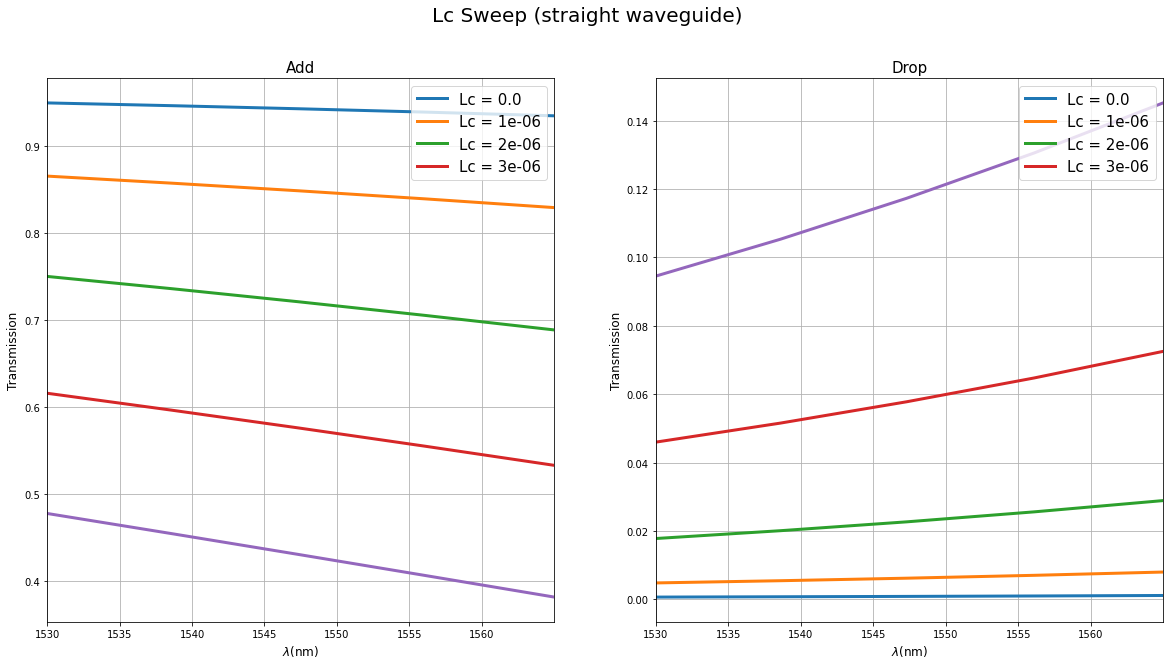

In [95]:
#Plots

figure14,fig = plt.subplots(1, 2, figsize=(20,10))

values = np.linspace(0, 4e-6, 5)
add = fdtd.getsweepresult('Lc Sweep', 'Port 2')
drop = fdtd.getsweepresult('Lc Sweep', 'Port 3')
wavelenght = add['lambda']
add = abs((add['T'])**2)
drop = np.transpose(abs((drop['T'])**2))
add = np.transpose(add)

for i in range(len(add)):
    aux = values[i]
    fig[0].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[0].set_ylabel("Transmission", fontsize = '12')
    fig[0].set_xlabel(r'$\lambda$(nm)', fontsize = '12')
    fig[0].set_xticks(np.arange(1530, 1565, step = 5), size = '12')
    fig[0].set_title('Add', size = 15)
    fig[0].legend(loc = 'upper right', prop = {'size': 15})
    fig[0].plot(wavelenght*1e9, add[i], label = 'Lc = ' + str(values[i]), linewidth = 3)

    fig[1].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[1].set_ylabel("Transmission", fontsize = '12')
    fig[1].set_xlabel(r'$\lambda$(nm)', fontsize = '12')
    fig[1].set_xticks(np.arange(1530, 1565, step = 5), size = '12')
    fig[1].set_title('Drop', size = 15)
    fig[1].legend(loc = 'upper right', prop = {'size': 15})
    fig[1].plot(wavelenght*1e9, drop[i], label = 'Lc = ' + str(values[i]), linewidth = 3)

    figure14.suptitle('Lc Sweep (straight waveguide)', size = '20')

fig[0].grid()
fig[1].grid()

plt.savefig("figure14")

Lc Sweep with an bent waveguide 3μm

In [101]:
# Guide modifications for the sweep

bendr = 3e-6

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 1',
  'x min'    : r -(width/2) + lc,
  'x max'    : r +(width/2) + lc,
  'y max'    : 0,
  'y min'    : -r,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 2',
  'x min'    : -(r +(width/2) + lc),
  'x max'    : -(r -(width/2) + lc),
  'y max'    : 0,
  'y min'    : -r,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 3',
  'x min'    : bendr -(width/2) + lc,
  'x max'    : bendr +(width/2) + lc,
  'y max'    : bendr + 2*r + width + gap,
  'y min'    : bendr + r + width + gap,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 4',
  'x max'    : -(bendr -(width/2) + lc),
  'x min'    : -(bendr +(width/2) + lc),
  'y max'    : bendr + 2*r + width + gap,
  'y min'    : bendr + r + width + gap,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.setnamed('Ring Resonator::outer_bottom',{'enabled' :  0})

fdtd.setnamed('Ring Resonator::arc2',{'enabled' :  0})

fdtd.setnamed('Ring Resonator::arc3',{'enabled' :  0})

fdtd.setnamed('FDTD', {
    'x'      : 0,
    'x span' : 5*r,
    'y'      : r,
    'y span' : 4*r,
    'z'      : 0,
})

fdtd.setnamed('Ring Resonator::outer_top', 'enabled', 0)

fdtd.addring()
fdtd.set({
'y'            : r + bendr + width + gap,
'z'            : height/2,
'z span'       : height,
'outer radius' :bendr +(width/2) + lc,
'inner radius' :bendr -(width/2) + lc,
'theta start'  : 180,
'theta stop'   : 360,
'material'     : material
})

fdtd.setnamed('FDTD::ports::port 1',{
  'y' : 2*r + gap + width + 1e-6,
  'injection axis' : 'y-axis',
  'x' : -r,
  'direction' :'Backward',
  'x span' : 2e-6,
  'z' : height/2,
})

fdtd.setnamed('FDTD::ports::port 2',{
  'y' : (2*r + gap + width + 1e-6),
  'injection axis' : 'y-axis',
  'x' : r,
  'x span' : 2e-6,
  'z' : height/2,
})

fdtd.setnamed('FDTD::ports::port 3',{
  'y' : -1e-6,
  'injection axis' : 'y-axis',
  'x' : r,
  'x span' : 2e-6,
  'z' : height/2,
})

fdtd.setnamed('FDTD::ports::port 4', {'enabled' : 0})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


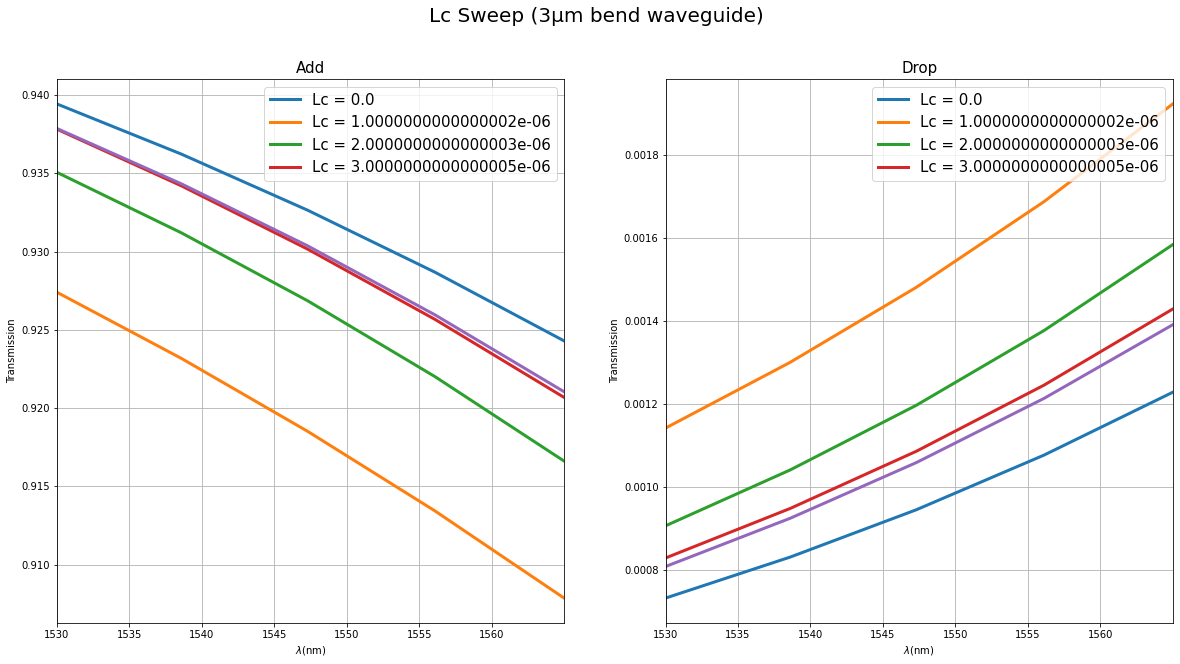

In [103]:
# Plots

figure15,fig = plt.subplots(1, 2, figsize=(20,10))

values = np.linspace(0, 5e-6, 6)
add = fdtd.getsweepresult('Lc Sweep3um', 'Port 2')
drop = fdtd.getsweepresult('Lc Sweep3um', 'Port 3')
wavelenght = add['lambda']
add = abs((add['T'])**2)
drop = np.transpose(abs((drop['T'])**2))
add = np.transpose(add)

for i in range(len(add)):
    aux = values[i]
    fig[0].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[0].set_ylabel("Transmission", fontsize = '10')
    fig[0].set_xlabel(r'$\lambda$(nm)', fontsize = '10')
    fig[0].set_xticks(np.arange(1530, 1565, step = 5), size = '10')
    fig[0].set_title('Add', size = 15)
    fig[0].legend(loc = 'upper right', prop = {'size': 15})
    fig[0].plot(wavelenght*1e9, add[i], label = 'Lc = ' + str(values[i]), linewidth = 3)

    fig[1].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[1].set_ylabel("Transmission", fontsize = '10')
    fig[1].set_xlabel(r'$\lambda$(nm)', fontsize = '10')
    fig[1].set_xticks(np.arange(1530, 1565, step = 5), size = '10')
    fig[1].set_title('Drop', size = 15)
    fig[1].legend(loc = 'upper right', prop = {'size': 15})
    fig[1].plot(wavelenght*1e9, drop[i], label = 'Lc = ' + str(values[i]), linewidth = 3)
    figure15.suptitle('Lc Sweep (3μm bend waveguide)', size = '20')

fig[0].grid()
fig[1].grid()

plt.savefig('figure15')


Lc Sweep with an bent waveguide 5μm

In [121]:
# Guide modifications for the sweep

bendr = 5e-6

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 1',
  'x min'    : r -(width/2) + lc,
  'x max'    : r +(width/2) + lc,
  'y max'    : 0,
  'y min'    : -r,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 2',
  'x min'    : -(r +(width/2) + lc),
  'x max'    : -(r -(width/2) + lc),
  'y max'    : 0,
  'y min'    : -r,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 3',
  'x min'    : bendr -(width/2) + lc,
  'x max'    : bendr +(width/2) + lc,
  'y max'    : bendr + 2*r + width + gap,
  'y min'    : bendr + r + width + gap,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.addrect()
fdtd.set({
  'name'     : 'Extension 4',
  'x max'    : -(bendr -(width/2) + lc),
  'x min'    : -(bendr +(width/2) + lc),
  'y max'    : bendr + 2*r + width + gap,
  'y min'    : bendr + r + width + gap,
  'z min'    : 0,
  'z max'    : height,
  'material' : material,
})

fdtd.setnamed('Ring Resonator::outer_bottom',{'enabled' :  0})

fdtd.setnamed('Ring Resonator::arc2',{'enabled' :  0})

fdtd.setnamed('Ring Resonator::arc3',{'enabled' :  0})

fdtd.setnamed('FDTD', {
    'x'      : 0,
    'x span' : 4*r,
    'y'      : 1.5*r,
    'y span' : 4*r,
    'z'      : 0,
})

fdtd.setnamed('Ring Resonator::outer_top', 'enabled', 0)

fdtd.addring()
fdtd.set({
'y'            : r + bendr + width + gap,
'z'            : height/2,
'z span'       : height,
'outer radius' :bendr +(width/2) + lc,
'inner radius' :bendr -(width/2) + lc,
'theta start'  : 180,
'theta stop'   : 360,
'material'     : material
})

fdtd.setnamed('FDTD::ports::port 1',{
  'y' : r + bendr + gap + width + 1e-6,
  'injection axis' : 'y-axis',
  'x' : -bendr,
  'direction' :'Backward',
  'x span' : 2e-6,
  'z' : height/2,
})

fdtd.setnamed('FDTD::ports::port 2',{
  'y' : (r + bendr + gap + width  + 1e-6),
  'injection axis' : 'y-axis',
  'x' : bendr,
  'x span' : 2e-6,
  'z' : height/2,
})

fdtd.setnamed('FDTD::ports::port 3',{
  'y' : -1e-6,
  'injection axis' : 'y-axis',
  'x' : r,
  'x span' : 2e-6,
  'z' : height/2,
})

fdtd.setnamed('FDTD::ports::port 4', {'enabled' : 0})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


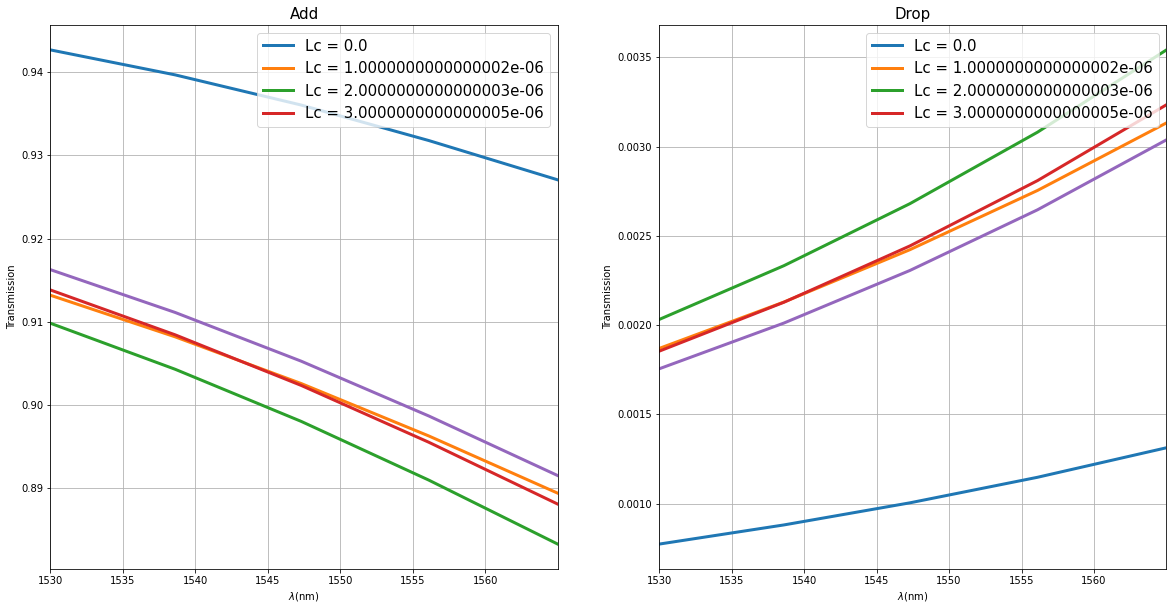

In [122]:
# Plots

figure16,fig = plt.subplots(1, 2, figsize=(20,10))

values = np.linspace(0, 5e-6, 6)
add = fdtd.getsweepresult('Lc Sweep5um', 'Port 2')
drop = fdtd.getsweepresult('Lc Sweep5um', 'Port 3')
wavelenght = add['lambda']
add = abs((add['T'])**2)
drop = np.transpose(abs((drop['T'])**2))
add = np.transpose(add)

for i in range(len(add)):
    fig[0].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[0].set_ylabel("Transmission", fontsize = '10')
    fig[0].set_xlabel(r'$\lambda$(nm)', fontsize = '10')
    fig[0].set_xticks(np.arange(1530, 1565, step = 5), size = '10')
    fig[0].set_title('Add', size = 15)
    fig[0].legend(loc = 'upper right', prop = {'size': 15})
    fig[0].plot(wavelenght*1e9, add[i], label = 'Lc = ' + str(values[i]), linewidth = 3)

    fig[1].set_xlim(Cband[0]*1e9,Cband[-1]*1e9)
    fig[1].set_ylabel("Transmission", fontsize = '10')
    fig[1].set_xlabel(r'$\lambda$(nm)', fontsize = '10')
    fig[1].set_xticks(np.arange(1530, 1565, step = 5), size = '10')
    fig[1].set_title('Drop', size = 15)
    fig[1].legend(loc = 'upper right', prop = {'size': 15})
    fig[1].plot(wavelenght*1e9, drop[i], label = 'Lc = ' + str(values[i]), linewidth = 3)
    figure15.suptitle('Lc Sweep (3μm bend waveguide)', size = '20')

fig[0].grid()
fig[1].grid()

plt.savefig('figure16')
